# „Short term performance of female vs male directors‘ dealings in shares of Nasdaq Composite Index companies in the period 2000 - 2023“
### Interdisciplinary Project: Annabel Resch, 11914287


## Table of Contents

[Step 1: Data Import](#step1)  

- [Download all data from website](#download)  
- [Data preprocessing](#prepro)  
- [Explorative Analysis](#explo)  

[Step 2: Director Classification](#step2)  

[Step 3 and 4: Calculate Abnormal Returns (AR)](#step3)  
- [Data import and preprocess daily company and market returns](#pp_dr)  
- [Calculate Abnormal Returns](#calcAR)

[Step 5: Data Analysis](#step5)  
- [Descriptive Statistics](#descr)  
- [Statistical Hypothesis Testing](#ttest)  
    - [Adjusted Standardized Cross-Sectional Test](#t1)  
    - [Generalized Rank Test](#t2)

[Step 6: Comparison and Visualizations](#vis)  
- [Correlation matrices](#corr)

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import warnings
import seaborn as sns
import re
from names_dataset import NameDataset
import time
import datetime 
import import_data
import matplotlib.pyplot as plt
import gender_classification
import calculate_AR
from eventstudystatistics import adjBMP, adjBMP_daily, grank
from IPython.display import clear_output

path = "/Users/admin/Documents/IP/data/"

RUN_IMPORT = False
RUN_PREPROCESSING = False 
RUN_CLASSIFICATION = False
RUN_DAILY_RETURNS = False
RUN_Calc_AR = False
RUN_statistics = False

warnings.filterwarnings('ignore')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Step 1: Data Import  <a class="anchor" id="step1"></a>

### Download all data from website <a class="anchor" id="download"></a>

We check 7669 distinct companies, which are currently or were in the past listend in the Nasdaq Composite Index.  
However, only those with listed director dealing(s) of trade type 'Sale' or 'Purchase' are added to the dataframe. 

In [2]:
if RUN_IMPORT == True:
    start_time = time.time()
    %run import_data.py
    print("--- %s minutes ---" % ((time.time() - start_time)/60))

### Preprocessing of downloaded data <a class="anchor" id="prepro"></a>

First of all, we import the 8 files containing the transactions

In [3]:
if RUN_PREPROCESSING == True: 
 
    files = os.listdir(path+"DD_download/")
    print(files)
    df = pd.DataFrame()
    
    for f in files[1:]:
        file = open(path+"DD_download/" + f, 'rb')
        data = pickle.load(file)
        file.close()
        df = pd.concat([df,data]) 

Now that we have our initial df set up, we can start analyzing the data and cleaning up the dataset.

In [4]:
isin = pd.read_excel(path+ 'Input/ISIN_merge.xlsx')
if RUN_PREPROCESSING == True: 
    # Quick quality check next
    # Drop all duplicates
    
    print("DF shape after immediate download: " + str(df.shape))
    print("Number of duplicate rows: " + str(df.duplicated().sum()))
    df.drop_duplicates(inplace=True)
    print("After deleting all duplicates: " + str(df.shape))
    
    # weirdly, all tickers start with a space 
    df.Ticker = df.Ticker.str[1:]
    
    print("Ticker is empty: "+str(df["original_Ticker"].isna().sum())) 
    tickers_input = isin['TICKER SYMBOL'].tolist()
    #print(len(TICKERS))
    
    tickers_output = df.Ticker.unique().tolist()
    no_DD = list(set(tickers_input) - set(tickers_output))
    pd.DataFrame(no_DD).to_excel(path+"report/Ticker_No_DD.xlsx")
    print("\n"+"No director dealing found: " + str(len(no_DD)))
    print("\n"+"Unique tickers in output download: " + str(len(tickers_output)))
    print("\n"+"Unique tickers in input excel: " + str(len(tickers_input)))

We have a large number of tickers in the df that are not in the original set, because the ticker name has changed over the years.
For that reason, I've added another column with the original ticker to the df during the import. 
After alignment with Prof. Aussenegg, I will drop all transactions, where OG Ticker != website Ticker! 

In [5]:
if RUN_PREPROCESSING == True: 

    not_in_list = list(set(tickers_output)-set(tickers_input))
   
    print("\n"+"Number of tickers that were not in the original list: " + str(len(not_in_list)))
    pd.DataFrame(not_in_list).to_excel(path+"report/Ticker_notin_OG.xlsx")
    
    print("\n"+"Before deleting Ticker mismatches: " + str(df.shape))
    ticker_mismatch = df[df["original_Ticker"] != df["Ticker"]]
    ticker_mismatch.to_excel(path+"report/tickers_deleted_notOG.xlsx")
    #just to be on the safe side both xlsx should be identical
    
    df = df[df["original_Ticker"] == df["Ticker"]]
    print("After deleting Ticker mismatches: " + str(df.shape))
    

But we have 2455 tickers in total with Ticker != OG Ticker. Because even if the Ticker is found in the original list, it is now assigned also to another transaction, that was originally done by another Ticker (e.g. NMRT). So we have 350 Tickers that are og tickers for some transaction but also appear as incorrect tickers for other transactions.

Okay, all unnecessary rows are deleted, now let's delete columns that we don't need.

In [6]:
if RUN_PREPROCESSING == True:    
    
# Let's see how many companies we have left with a DD
    
    print("\n"+ "Out of " + str(len(tickers_input))+" initial companies, " + str(len(set(df.Ticker.tolist()))) +" have listed a directors' Sale' or 'Purchase'.")
    
# We only keep columns with valuable information

    df.columns = ['X', 'Filing Date' , 'Trade Date','Ticker','Insider Name','Title','Trade Type',
     'Price','Qty','Owned','ΔOwn',"Value",'1d','1w','1m','6m','original_Ticker','Company Name']
    df = df[[ 'Filing Date', 'Trade Date', 'Ticker', 'Insider Name', 'Title', 'Trade Type','Price','Qty','Owned','ΔOwn',"Value"]]

# Save the preprocessed file
    df.to_pickle(path+"Transactions_preprocessed.pkl")

else: 
    df = pd.read_pickle(path+"Transactions_preprocessed.pkl")

In [7]:
df.head(3)

,Filing Date,Trade Date,Ticker,Insider Name,Title,Trade Type,Price,Qty,Owned,ΔOwn,Value
0,2022-03-25 16:36:22,2021-12-02,SATS,Wade William David,Dir,P - Purchase,$27.03,+443,443,New,"+$11,974"
1,2022-03-14 16:39:07,2022-03-10,SATS,Dodge R Stanton,Dir,P - Purchase,$24.17,"+20,500","21,011",>999%,"+$495,485"
2,2021-03-01 18:39:03,2021-02-25,SATS,Johnson Anders N,"CSO, Pres - ESS",P - Purchase,$23.45,"+20,000","23,064",+653%,"+$469,000"


We need to add the ISIN Code for each company, because that will be used as unique key when joining with the daily return data. 

In [8]:
df = df.merge(isin,left_on="Ticker", right_on="TICKER SYMBOL", how='left').drop(columns="TICKER SYMBOL")

In [9]:
not_found = df[df["ISIN CODE"].isna()]
print("Transactions without ISIN Code: " +str(len(not_found))+ ". TICKERS: " + str(not_found["Ticker"].unique()))
df.dropna(subset=['ISIN CODE'], inplace=True)

Transactions without ISIN Code: 6. TICKERS: ['PBBI']


Only one Ticker 'PBBI' cannot be matched to an ISIN code. Those transactions will be disregarded in the analysis.

Data Quality check: If several DD of the same type and of the same person take place on the same day, then these transactions
should be condensed to one transaction.  
We need to normalize the filing date for that first. Thus, we drop the time and only keep the date. 

In [10]:
df["Filing Date"] = df['Filing Date'].apply(lambda x: pd.to_datetime(x).normalize())
df[df.duplicated(subset=['Filing Date', 'Insider Name','Ticker','Trade Type'],keep=False)].to_excel(path + "report/DD_sameDayPerson.xlsx")
df.drop_duplicates(subset=['Filing Date', 'Insider Name','Ticker','Trade Type'], keep='first',inplace=True)

print(df.shape)

(601535, 12)


We have 31.304 DD of the same person on the same day, sometimes even more than 2. We are deleting 19.681 transactions. (last checked 17.02.24)

### Explorative Analysis of Transactions <a class="anchor" id="explo"></a>

Let's see how many director dealings the companies have in average.

In [11]:
x = df.groupby('Ticker')['Filing Date'].agg('count').reset_index()
print("Mean of transactions per company: "+ str(x["Filing Date"].mean()))
print("Median of transactions per company: "+ str(x["Filing Date"].median()))
print("Max number of transactions per company: "+ str(x["Filing Date"].max())+". Company ticker: "+str(x.sort_values(by="Filing Date",ascending =False)[:1].Ticker))

# To see which companies have the most transactions:
x.sort_values(by="Filing Date",ascending =False)[:5]

Mean of transactions per company: 103.30328009617035
Median of transactions per company: 48.0
Max number of transactions per company: 8978. Company ticker: 2746    ISCA
Name: Ticker, dtype: object


,Ticker,Filing Date
2746,ISCA,8978
3386,MORN,2158
5017,SYBT,1949
4275,QCOM,1945
5402,UTHR,1822


In [12]:
print(x.sort_values(by="Filing Date",ascending =False)[:5].to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
Ticker &  Filing Date \\
\midrule
  ISCA &         8978 \\
  MORN &         2158 \\
  SYBT &         1949 \\
  QCOM &         1945 \\
  UTHR &         1822 \\
\bottomrule
\end{tabular}



## Step 2: Director Classification <a class="anchor" id="step2"></a>

In this step, we classify the directors into male or female, based on the directors’ name. The gender will be saved in a new column  "Gender".

In [13]:
if RUN_CLASSIFICATION == True:
    start_time = time.time()    
    
    names = df['Insider Name'].unique()
    print("Number of unique names: " + str(len(names)))
    
    gender_all = gender_classification.classify(names)
    
    df["Gender"] = df["Insider Name"].apply(lambda x: gender_all.get(x))
        
    df.to_pickle(path+"df_incl_gender.pkl")
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    
else: 
    df = pd.read_pickle(path +"df_incl_gender.pkl")
    print(df.shape)

(601535, 13)


In [14]:
df.shape

(601535, 13)

### Explorative Analysis: Gender Distribution

In [15]:
x = df.groupby('Insider Name')['Filing Date'].agg('count').reset_index()
x.sort_values(by="Filing Date",ascending =False)[:5]
print(x.sort_values(by="Filing Date",ascending =False)[:5].to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
                       Insider Name &  Filing Date \\
\midrule
             Frost Phillip Md Et Al &         1471 \\
                  Mansueto Joseph D &          915 \\
                Rothblatt Martine A &          793 \\
                  Kodosky Jeffrey L &          645 \\
Marxe Austin W \& Greenhouse David M &          625 \\
\bottomrule
\end{tabular}



In [16]:
gender_dist = df.drop_duplicates(subset=["Insider Name"], keep='first')
length = gender_dist.shape[0]
male = len(gender_dist[gender_dist.Gender =='Male'])/length
female = len(gender_dist[gender_dist.Gender =='Female'])/length
na = len(gender_dist[gender_dist.Gender =='na'])/length

d = {'Gender': ['male','female','na'], 'count': [male,female,na]}
dist = pd.DataFrame(data=d)

print("\n"+"Out of " +str(length)+ " directors, " + str(np.round((male*100),2))+"% are male directors, " + str(np.round((female*100),2))+ "% are made by female directors " + str(np.round((na*100),2))+"% are not identifiable.")



Out of 65856 directors, 82.27% are male directors, 13.3% are made by female directors 4.41% are not identifiable.


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python

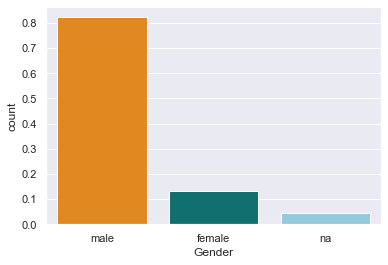

In [17]:

#col=sns.color_palette("pastel")
col=["darkorange","teal","skyblue"]
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(data=dist, x="Gender", y="count",palette=col)

#ax.bar_label(ax.containers[0], fmt='%.3f')
plt.savefig(path+"/Vis/"+"bar_dist_gender", dpi=600, bbox_inches='tight')

plt.show()


Out of 601535 total transactions, 85.22% are made by male directors, 10.55% are made by female directors and 4.22% are not identifiable.


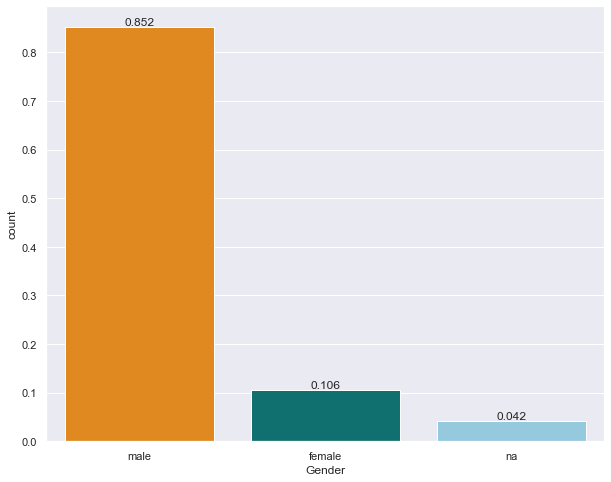

In [18]:
male = len(df[df.Gender =='Male'])/df.shape[0]
female = len(df[df.Gender =='Female'])/df.shape[0]
na = len(df[df.Gender =='na'])/df.shape[0]

d = {'Gender': ['male','female','na'], 'count': [male,female,na]}
dist = pd.DataFrame(data=d)

print("\n"+"Out of " +str(df.shape[0])+ " total transactions, " + str(np.round((male*100),2))+"% are made by male directors, " + str(np.round((female*100),2))+ "% are made by female directors and " + str(np.round((na*100),2))+"% are not identifiable.")

#col=sns.color_palette("pastel")
col=["darkorange","teal","skyblue"]
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(data=dist, x="Gender", y="count",palette=col)

ax.bar_label(ax.containers[0], fmt='%.3f')
plt.savefig(path+"/Vis/"+"bar_dist_dd", dpi=600, bbox_inches='tight')

plt.show()

We will drop all transactions made by a director, that cannot be classified to a gender. This can have different reasons, which will be further explained in the final report. 

In [19]:
print("Number of dropped rows, which cannot be classified to a gender: " + str(len(df[df.Gender =='na'])) + " + " + str(len(df[df.Gender.isna()])))
df[df.Gender =='na'].to_excel(path + "report/NAs.xlsx")
df[df.Gender.isna()].to_excel(path + "report/isna().xlsx")
df = df.dropna(subset=["Gender"])
df = df[df["Gender"]!="na"]
print("DF shape after NAs got dropped: " + str(df.shape))

df.to_pickle(path+"df_gender_cleaned.pkl")

Number of dropped rows, which cannot be classified to a gender: 25368 + 89
DF shape after NAs got dropped: (576078, 13)


In [20]:
df = pd.read_pickle(path +"df_gender_cleaned.pkl")

In [21]:
df.shape

(576078, 13)

Extremely unbalanced dataset, thus we will try out over- and undersampling techniques

1. Undersampling of male transactions

2. Oversampling of female transactions

## Step 3&4: Calculate (Cumulative) Abnormal Returns <a class="anchor" id="step3"></a>


### Import and preprocess daily company and market returns <a class="anchor" id="pp_dr"></a>

In [22]:
if RUN_DAILY_RETURNS == True:
    # first we import the daily returns of the companies
    files = os.listdir(path+"daily/") #8 individual files
    
    daily = pd.DataFrame()
    
    for f in files:
        print(f)
        data = pd.read_excel(path+"daily/"+f,skiprows=5)
        data = data.iloc[1:]
        #transpose isins to row idx
        data = data.transpose()
        #make columns = days 
        data.columns = data.iloc[0]
        data = data.iloc[1:]

        daily = pd.concat([daily,data])
        
    # need to drop this, because company has no daily prices but only value: $$ER: 2381,NO DATA AVAILABLE
    daily = daily.drop('MHY8900D1085') # not in the transactions anyways
    daily.to_pickle(path + "daily.pkl") #daily prices, before calculation of daily return
    DR_companies = daily.pct_change(axis='columns', periods=1)
    DR_companies.replace([np.inf, -np.inf], np.nan, inplace=True)
    DR_companies.to_pickle(path + "DR_companies.pkl")
    
    #Let's also import the daily returns of the market
    daily_market = pd.read_excel(path+"Input/Nasdaq Composite Index (RI (Totlal Return) and PI (Price Index)) 07_1999 - 07_2023.xlsx")
    daily_market.drop([0,1,2,4], inplace=True)
    daily_market = daily_market.transpose()
    daily_market.columns = daily_market.iloc[0]
    daily_market = daily_market.iloc[1:]
    daily_market = daily_market.set_index('Code')

    DR_market = daily_market.pct_change(axis='columns', periods=1)
    DR_market.to_pickle(path + "DR_market.pkl")

else:
    DR_companies = pd.read_pickle(path + "DR_companies.pkl")
    DR_market = pd.read_pickle(path + "DR_market.pkl")

### Calculate Abornal Returns <a class="anchor" id="calcAR"></a>

Let's check if all the ISIN Codes are also found in the daily return company list. 
If we have no daily returns for a company, we cannot calculate the AR and therefore drop those rows/transactions.

In [23]:
df_isins = df["ISIN CODE"].tolist()
dr_isins = DR_companies.index.values.tolist()

isin_not_in_dr = set(df_isins)-set(dr_isins)
print("Number of distinct ISIN Codes not found in daily returns list: " +str((len(isin_not_in_dr))))
pd.DataFrame(isin_not_in_dr).to_excel(path+"report/ISIN_notinDR.xlsx")
df = df[~df['ISIN CODE'].isin(isin_not_in_dr)]
print("\nDf shape after dropping companies, for which we don't have daily returns: " + str(df.shape))


Number of distinct ISIN Codes not found in daily returns list: 121

Df shape after dropping companies, for which we don't have daily returns: (571674, 13)


Some more preprocessing before calculating the individual Abnormal Returns.
For the (C)AR calculations, we need sufficient past daily returns and also a long enough timeframe for the future predictions. 
Thus, we drop all transactions that are too recent (event window too small), as well as all transactions before 01.01.2003. 

In [24]:
print("Number of transactions after January 01 (too recent): " + str(len(df[df['Filing Date'] > "2023-01-01 00:00:00"])))
df[df['Filing Date'] > "2023-01-01 00:00:00"].to_excel(path+"report/FilingDate_toorecent.xlsx")
df = df.drop(df[df['Filing Date'] > "2023-01-01 00:00:00"].index)
print(df.shape)

print("\n"+"Number of transactions before 1.8.2004 (no market RI data before Sept 03): " + str(len(df[df['Filing Date'] < "2004-08-01 00:00:00"])))
df = df.drop(df[df['Filing Date'] < "2004-08-01 00:00:00"].index)
df.to_pickle(path+"df_prepocessed.pkl")
#df = pd.read_pickle(path+"df_prepocessed.pkl")
df.shape

Number of transactions after January 01 (too recent): 21084
(550590, 13)

Number of transactions before 1.8.2004 (no market RI data before Sept 03): 31821


(518769, 13)

In [25]:
DR_companies.replace(np.nan, 0.0, inplace=True)

In [26]:
DR_companies.isna().sum().value_counts()

0    6263
dtype: int64

In [27]:
df.shape

(518769, 13)

In [28]:
if RUN_Calc_AR == True:
    mr = DR_market[:1]
    cols = [str(item)for item in range(-20,21)]
    start_time = time.time()
    empty_ = pd.DataFrame(np.zeros((1, 41))).astype("float32")
    empty_all = []
    est_window_market = []
    event_window_market= []
    eps=[]
    
    for i in range(4):
        
        scope = np.ceil(df.shape[0]/4).astype("int64")
        print(i)
        start = i*scope
        end = start+scope
        print(start,end)
        
        # cr = company daily return, mr = market daily return
        ARs = pd.DataFrame()
        count = 1 # DQ check in case of error
        
        for v in df.values[start:end,:]:

            event_date = v[0]
            isin = v[-2]
            #print(isin)
            cr = DR_companies.loc[isin]
            
            abnormal_returns,est_window_market_idv,event_window_market_idv,eps_idv = calculate_AR.run_calculation_AR(event_date,cr,mr)
            
            check_if_empty = (abnormal_returns == empty_).all()
            if (check_if_empty == True).all():
                empty_all.append(abnormal_returns)
            else:
                est_window_market.append(est_window_market_idv)
                event_window_market.append(event_window_market_idv)
                eps.append(eps_idv)
                
            ARs = pd.concat([ARs,pd.DataFrame(abnormal_returns)])

            count+=1
            
        ARs.columns = cols
        print(ARs.shape)
        #print(df[start:end].shape)
        df_all = pd.concat([df[start:end].reset_index(drop=True), ARs.reset_index(drop=True)], axis=1)
        print(df_all.shape)

        # preprocessing: drop all empty rows with no AR
        df_subset = df_all.iloc[:, 13:54]
        df_subset['matching'] = df_subset.eq(df_subset.iloc[:,0], axis=0).all(1)
        drop_idx = df_subset[df_subset["matching"]==True].index.tolist()
        print("Number of empty (only 0s) ARs: " + str(len(drop_idx)))
        ARs =  df_all.drop(df_all.index[d] for d in drop_idx)     
       
        ARs.to_pickle(path +"/ARs/" +f"ARs_{i}.pkl")

        print("--- %s minutes ---" % ((time.time() - start_time)/60))
         
    with open(path+'est_window_market.pkl', 'wb') as f:
           pickle.dump(est_window_market, f)

    with open(path+'event_window_market.pkl', 'wb') as f:
           pickle.dump(event_window_market, f)

    with open(path+'empty_all.pkl', 'wb') as f:
           pickle.dump(empty_all, f)
            
    with open(path+'eps.pkl', 'wb') as f:
           pickle.dump(eps, f)
            
    ARs = pd.DataFrame()
    for i in range(4):
        part = pd.read_pickle(path+"/ARs/" +f"ARs_{i}.pkl")
        print(part.shape)
        ARs = pd.concat([ARs,part])
    print(ARs.shape)
    ARs = ARs.reset_index(drop=True)
    
else:
    ARs = pd.DataFrame()
    for i in range(4):
        part = pd.read_pickle(path+"/ARs/" +f"ARs_{i}.pkl")
        print(part.shape)
        ARs = pd.concat([ARs,part])
    print(ARs.shape)
    ARs = ARs.reset_index(drop=True)    
    
    est_window_market = pd.read_pickle(path+"est_window_market.pkl")
    event_window_market= pd.read_pickle(path+"event_window_market.pkl")
    empty_all = pd.read_pickle(path+"empty_all.pkl") 
    eps = pd.read_pickle(path+"eps.pkl") 

(122260, 54)
(121330, 54)
(118923, 54)
(119701, 54)
(482214, 54)


There are some outliers, which skew the visualizations below drastically. Thus, I dropped the individual transactions from the dataframe

??? Bis wann zählt es als Outlier?? 

In [29]:
len(empty_all)

36555

In [30]:
len(event_window_market)

482214

In [50]:
ARs.Ticker.nunique()

4841

In [31]:
ARs = pd.DataFrame()
for i in range(4):
    part = pd.read_pickle(path+"/ARs/" +f"ARs_{i}.pkl")
    print(part.shape)
    ARs = pd.concat([ARs,part])
print(ARs.shape)
ARs = ARs.reset_index(drop=True)

(122260, 54)
(121330, 54)
(118923, 54)
(119701, 54)
(482214, 54)


In [32]:
ARs.shape

(482214, 54)

In [33]:
CARs = ARs.iloc[:, 13:54].cumsum(axis=1)
CARs = pd.concat([ARs.iloc[:,0:13],CARs],axis=1)
CARs.to_pickle(path+"CARs.pkl")

Visualize Average Abnormal Returns

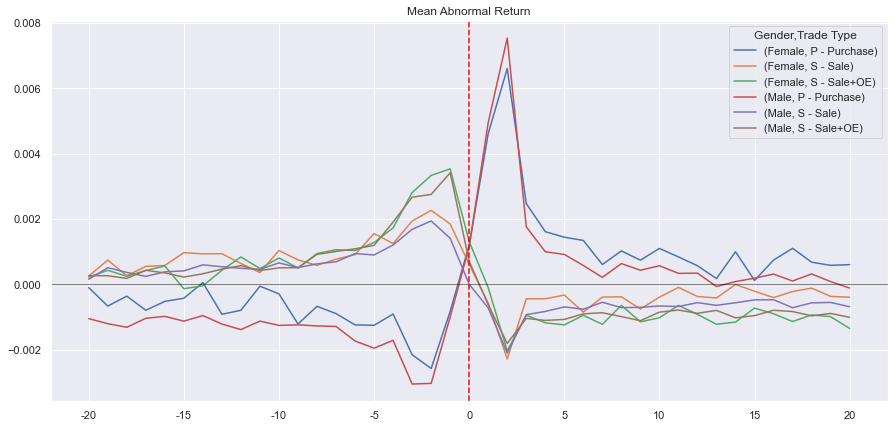

In [34]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

fig = ARs.groupby(["Gender","Trade Type"]).mean().transpose().plot()
fig.set_title("Mean Abnormal Return")
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/AAR", dpi=600, bbox_inches='tight')
plt.show()

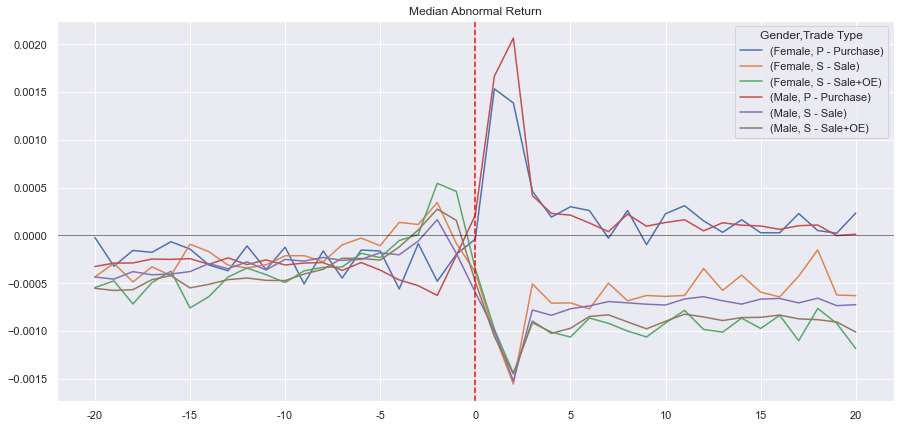

In [35]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

fig = ARs.groupby(["Gender","Trade Type"]).median().transpose().plot()
fig.set_title("Median Abnormal Return")
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/MAR", dpi=600, bbox_inches='tight')
plt.show()

## Step 5: Data Analysis // Statistical Testing <a class="anchor" id="step5"></a>

### Cross Sectional Analysis of descriptive statistics  <a class="anchor" id="descr"></a>

In [36]:
groups= ARs.groupby(["Gender","Trade Type"]).size().to_frame(name = 'count').reset_index() 
groups["Share"] = np.round((groups["count"]/ARs.shape[0])*100,2).apply(lambda x: str(x)+"%")
groups

,Gender,Trade Type,count,Share
0,Female,P - Purchase,13379,2.77%
1,Female,S - Sale,19468,4.04%
2,Female,S - Sale+OE,19758,4.1%
3,Male,P - Purchase,118179,24.51%
4,Male,S - Sale,169920,35.24%
5,Male,S - Sale+OE,141510,29.35%


In [37]:
print(groups.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{llrl}
\toprule
Gender &   Trade Type &  count &  Share \\
\midrule
Female & P - Purchase &  13379 &  2.77\% \\
Female &     S - Sale &  19468 &  4.04\% \\
Female &  S - Sale+OE &  19758 &   4.1\% \\
  Male & P - Purchase & 118179 & 24.51\% \\
  Male &     S - Sale & 169920 & 35.24\% \\
  Male &  S - Sale+OE & 141510 & 29.35\% \\
\bottomrule
\end{tabular}



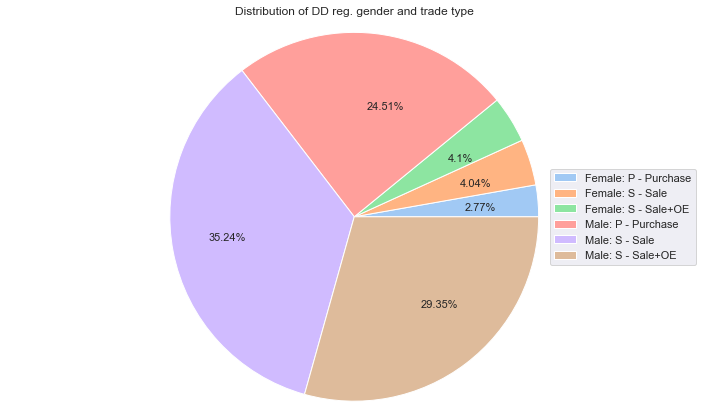

In [38]:
label =groups["Gender"]+": "+groups["Trade Type"]
colors = sns.color_palette('pastel')[0:7]
plt.figure(figsize=(10,6))
#create pie chart
patches, texts =plt.pie(groups["count"],labels=groups["Share"], labeldistance = 0.6,colors = colors)
plt.title("Distribution of DD reg. gender and trade type")
plt.legend(patches, label, loc="center right")
plt.savefig(path+"/Vis/Pie_dist_Groups", dpi=600, bbox_inches='tight')

plt.axis('equal')
plt.tight_layout()
plt.show()


In [39]:
ARs.shape

(482214, 54)

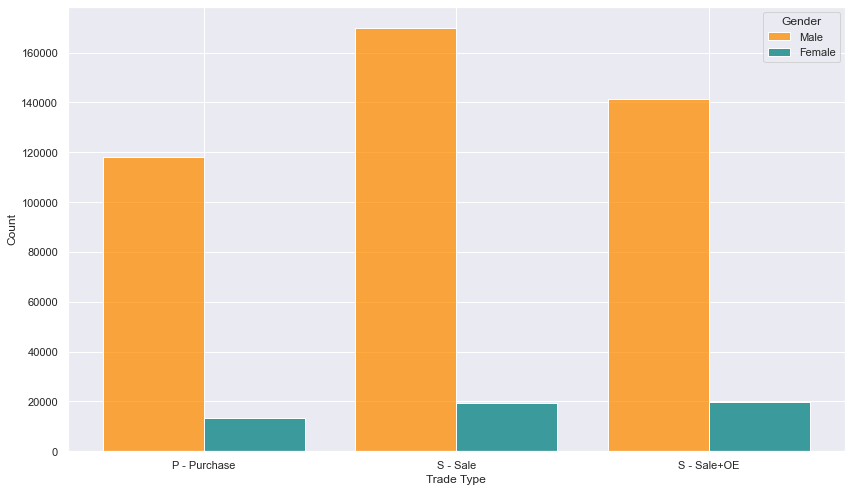

In [40]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(12,7)})
col=["darkorange","teal"]
sns.histplot(data = ARs, x="Trade Type", hue="Gender", multiple ="dodge",shrink=.8,palette=col)

plt.savefig(path+"/Vis/bar_Groups", dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [41]:
#ARs.groupby(["Gender","Trade Type"]).size().to_frame(name = 'count').reset_index() 

CAAR = CARs.groupby(["Gender","Trade Type"]).mean().transpose()
MCAR = CARs.groupby(["Gender","Trade Type"]).median().transpose()

print(CAAR.describe().to_latex(index=False,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{rrrrrr}
\toprule
      Female & \multicolumn{3}{l}{Male} \\
P - Purchase & S - Sale & S - Sale+OE & P - Purchase & S - Sale & S - Sale+OE \\
\midrule
     41.0000 &  41.0000 &     41.0000 &      41.0000 &  41.0000 &     41.0000 \\
     -0.0010 &   0.0107 &      0.0087 &      -0.0122 &   0.0059 &      0.0079 \\
      0.0081 &   0.0053 &      0.0066 &       0.0070 &   0.0043 &      0.0060 \\
     -0.0167 &   0.0003 &      0.0002 &      -0.0290 &  -0.0000 &      0.0003 \\
     -0.0061 &   0.0072 &      0.0029 &      -0.0152 &   0.0025 &      0.0026 \\
     -0.0018 &   0.0117 &      0.0072 &      -0.0103 &   0.0052 &      0.0064 \\
      0.0060 &   0.0143 &      0.0135 &      -0.0080 &   0.0086 &      0.0126 \\
      0.0124 &   0.0197 &      0.0217 &      -0.0011 &   0.0146 &      0.0201 \\
\bottomrule
\end{tabular}



Visualize descriptive stats

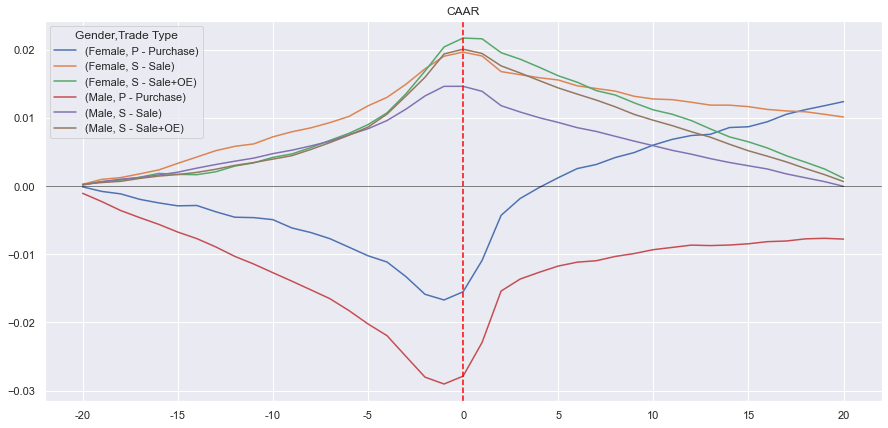

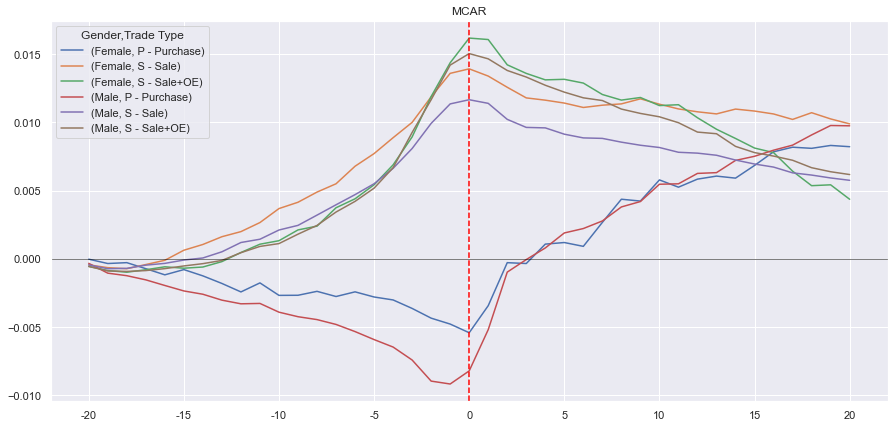

In [42]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

CAAR['Day'] = CAAR.index
fig = CAAR.plot().set_title("CAAR")
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/CAAR", dpi=600, bbox_inches='tight')
plt.show()

MCAR['Day'] = MCAR.index
fig = MCAR.plot().set_title("MCAR")
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/MCAR", dpi=600, bbox_inches='tight')
plt.show()

101.0
104.62443046213929


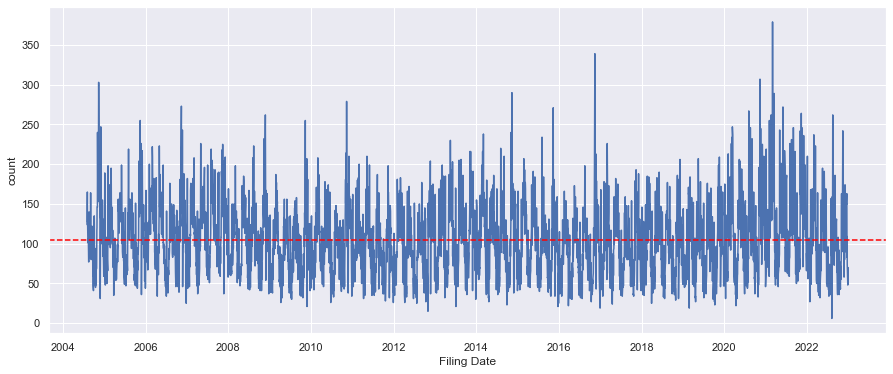

In [43]:
dates_cluster = ARs.groupby(["Filing Date"]).size().to_frame(name = 'count').reset_index() 
print(dates_cluster["count"].median())
print(dates_cluster["count"].mean())

plt.figure(figsize=(15,6))
sns.lineplot(data=dates_cluster, x="Filing Date", y="count")
plt.axhline(y=dates_cluster["count"].mean(),color="red",ls="--")

plt.savefig(path+"/Vis/dates_cluster", dpi=600, bbox_inches='tight')

In [44]:
top10_dates = dates_cluster.sort_values(by="count", ascending=False)[:10]
print(top10_dates.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
Filing Date &  count \\
\midrule
 2021-03-03 &    379 \\
 2016-11-14 &    339 \\
 2020-11-12 &    307 \\
 2004-11-12 &    303 \\
 2014-11-12 &    290 \\
 2021-03-17 &    289 \\
 2010-11-12 &    279 \\
 2006-11-13 &    273 \\
 2021-06-03 &    272 \\
 2015-11-12 &    271 \\
\bottomrule
\end{tabular}



### Let's analyze the different time frames

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=7.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:f

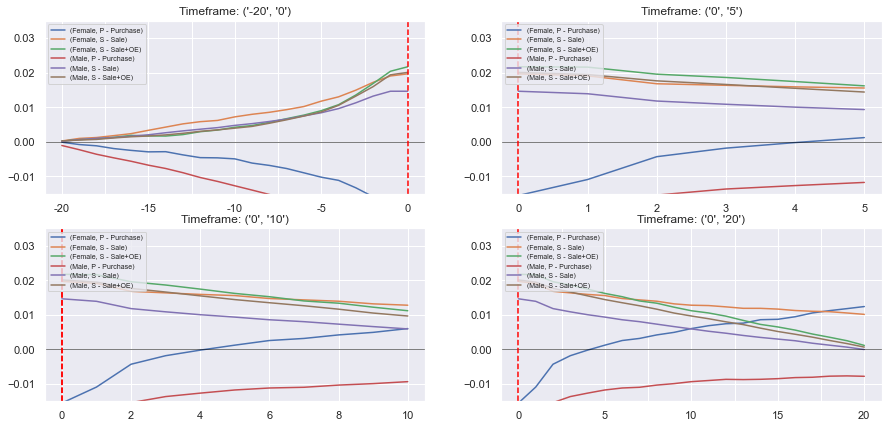

In [45]:
stats = pd.DataFrame()
timeframes = [("-20","0"),("0","5"),("0","10"),("0","20")]
row,col = 0,0

fig, axs = plt.subplots(ncols=2,nrows=2)
plt.figsize=(10,10)

for tf in timeframes:
    timeframe = CAAR.loc[tf[0]:tf[1]]

    fig = timeframe.plot(ax=axs[col][row])
    fig.set_title("Timeframe: "+str(tf))
    fig.axhline(0,color="black",linewidth=0.5)
    
    fig.legend(fontsize="7" ,loc="upper left")
    fig.set(ylim=(-0.015,0.035))
    if (row == 0) & (col==0):
        row=1
        fig.axvline(x=20,color="red",ls="--") 
    elif (row == 0) & (col==1):
        row=1
        col=1
        fig.axvline(x=0,color="red",ls="--")
    elif (row == 1) & (col==0):
        row=0
        col=1 
        fig.axvline(x=0,color="red",ls="--")
    if (row == 1) & (col==1):
        fig.axvline(x=0,color="red",ls="--")    
    #let's collect the stats for each timeframe
    descr_stats =CAAR.describe().transpose()
    descr_stats["timeframe"]=str(tf)
    stats = pd.concat([stats,descr_stats])
    
plt.savefig(path+"/Vis/tfs", dpi=600, bbox_inches='tight')
plt.show()    

## Statistical Hypothesis Testing  <a class="anchor" id="ttest"></a>

In [46]:
if RUN_statistics == True: 
    np.seed = 1234
    CAR_periods=[[0, 19], [20, 40],[20, 25],[20, 21]]
    print_period = ["[-20,-1]", "[0,20]","[0,5]","[0,1]"]
    Genders = ["Male","Female"]
    Transaction_type = ["P - Purchase", "S - Sale", "S - Sale+OE"]

    test_results = []
    test_index = []

    for gen in Genders:
        for type_ in Transaction_type:
            count = 0
            for CAR_period in CAR_periods:

                print(gen)
                print(type_)
                print(CAR_period)
                period = str(CAR_period)

                df = ARs[(ARs['Gender'] == gen) & (ARs['Trade Type'] == type_)].iloc[:,13:54]
                idx_list = list(df.index.values)

                AR = np.asarray(df.values)
                eps_ = np.array(np.squeeze([eps[i] for idx in idx_list]))
                event_window_market_ = np.array(np.squeeze([event_window_market[i] for idx in idx_list]))
                est_window_market_ = np.array(np.squeeze([est_window_market[i] for idx in idx_list]))

                grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, False)
                adj_grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, True)
                adjBMP_result = adjBMP(AR, eps_, est_window_market_, event_window_market_, CAR_period)

                CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
                test_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
                test_index.append((gen, type_, print_period[count]))
                count+=1
                
    test_results_df = pd.DataFrame(test_results)
    test_results_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adj-GRANK p-value", "adj-GRANK statistic", "adjBMP p-value", "adjBMP t-statistic"]
    test_results_df.index =pd.MultiIndex.from_tuples(test_index, names=("Gender", "Trade Type", "CAR Period"))
    test_results_df.to_pickle(path+"test_results.pkl")
else: 
    test_results_df = pd.read_pickle(path+'test_results.pkl')

# Report stuff

Create tables for latex report

In [47]:
purchase = test_results_df[np.in1d(test_results_df.index.get_level_values(1), ['P - Purchase'])][['CAAR', 'GRANK p-value', 'GRANK t-statistic', 'adjBMP p-value', 'adjBMP t-statistic']]
sales = test_results_df[np.in1d(test_results_df.index.get_level_values(1), ['S - Sale'])][['CAAR', 'GRANK p-value', 'GRANK t-statistic', 'adjBMP p-value', 'adjBMP t-statistic']]
SOE = test_results_df[np.in1d(test_results_df.index.get_level_values(1), ['S - Sale+OE'])][['CAAR', 'GRANK p-value', 'GRANK t-statistic', 'adjBMP p-value', 'adjBMP t-statistic']]

In [48]:
print(purchase.droplevel('Trade Type').to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))
print(sales.droplevel('Trade Type').to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))
print(SOE.droplevel('Trade Type').to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llrrrrr}
\toprule
       &       &    CAAR &  GRANK p-value &  GRANK t-statistic &  adjBMP p-value &  adjBMP t-statistic \\
Gender & CAR Period &         &                &                    &                 &                     \\
\midrule
Male & [-20,-1] & -0.0286 &         0.8382 &             0.2045 &          0.9522 &             -0.0599 \\
       & [0,20] &  0.0210 &         0.7763 &             0.2846 &          0.9667 &              0.0417 \\
       & [0,5] &  0.0168 &         0.7681 &             0.2952 &          0.9077 &              0.1159 \\
       & [0,1] &  0.0059 &         0.8030 &             0.2498 &          0.9082 &              0.1154 \\
Female & [-20,-1] & -0.0159 &         0.9755 &             0.0308 &          0.7601 &             -0.3053 \\
       & [0,20] &  0.0251 &         0.7692 &             0.2938 &          0.5879 &              0.5419 \\
       & [0,5] &  0.0155 &         0.7705 &             0.2921 &          0.5474 &              0.

In [59]:
CARs.Title.value_counts()[0:20]

Dir                  136408
10%                   23999
Pres, CEO             22165
CEO                   15815
CFO                   15484
Dir, 10%              10117
EVP                    9439
SVP                    7279
Group Member, 10%      6477
COB, CEO               5918
COO                    5583
EVP, CFO               5516
Pres                   4954
VP                     3991
CEO, Pres              3937
Pres, COO              3583
SVP, CFO               3414
CEO, 10%               3398
CTO                    3359
See Remarks            2903
Name: Title, dtype: int64

In [63]:
CARs.ΔOwn.value_counts()[0:20]

0%       74403
-1%      39502
-2%      26513
-100%    21152
-3%      19591
+1%      19456
-4%      15615
-5%      13283
-6%      11421
-7%       9817
+2%       9335
-8%       8569
-9%       7727
-10%      7232
-11%      6472
New       6177
+3%       6051
-12%      5901
-13%      5437
-14%      5122
Name: ΔOwn, dtype: int64

In [69]:
CARs.ΔOwn.max()

'New'

In [70]:
CARs.ΔOwn.min()

'+1%'